In [1]:
import time
start = time.time()
name = 'MedicineImageClassifier'

In [2]:
# !pip install split-folders

In [3]:
# import splitfolders

# input_folder = '/content/drive/MyDrive/archive/Drug Vision/Data Combined'
# splitfolders.ratio(input_folder, output="/content/drive/MyDrive/archive/Drug Vision/Data Combined/SplitImages", 
#                     seed=42, ratio=(.7, .3), 
#                     group_prefix=None)

In [4]:
import os
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, MaxPooling2D, Conv2D, Dense
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

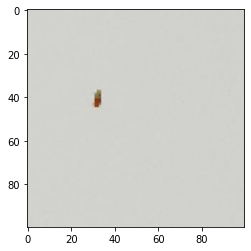

In [5]:
img_array = cv2.imread('/content/drive/MyDrive/archive/Drug Vision/Data Combined/Alaxan/00000003.jpg')
img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
img_array = cv2.resize(img_array, (100, 100))
plt.imshow(img_array)
plt.show()

In [6]:
categories = ['Alaxan', 'Bactidol', 'Bioflu', 'Biogesic', 'DayZinc', 'Decolgen', 'Fish Oil', 'Kremil S', 'Medicol', 'Neozep']
IMG_Size = 100

In [7]:
train_data_path = '/content/drive/MyDrive/archive/Drug Vision/Data Combined/SplitImages/train'
test_data_path = '/content/drive/MyDrive/archive/Drug Vision/Data Combined/SplitImages/val'

In [8]:
training_data = []
test_data = []

def create_data(my_data_path,my_data):
    for ct in categories:
      path = os.path.join(my_data_path,ct)
      class_num = categories.index(ct)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img))
          img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
          img_array = cv2.resize(img_array, (100, 100))
          my_data.append([img_array,class_num])
        except Exception as e:
          pass

In [9]:
img_size = 200
batch_size = 32

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True)
    
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(train_data_path,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 7000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


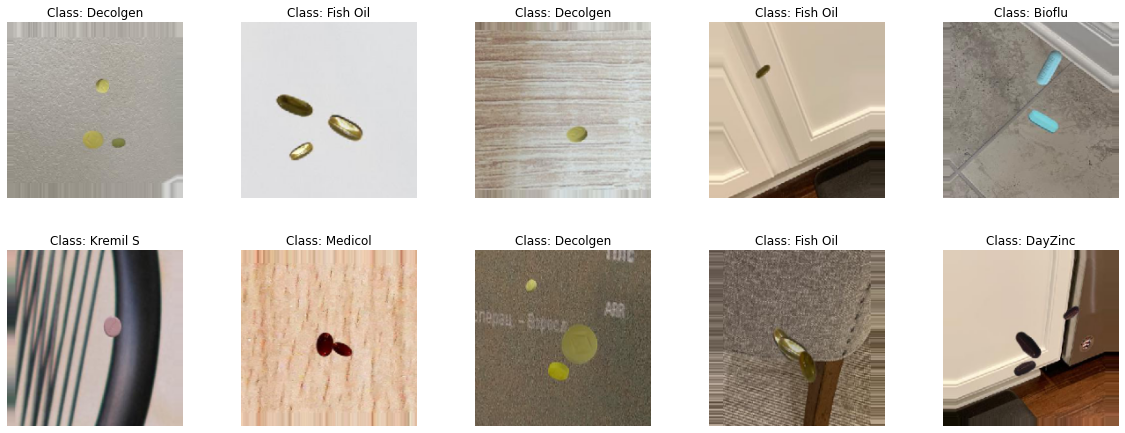

In [10]:
labels = [k for k,v in train_generator.class_indices.items()]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(10):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [11]:
create_data(train_data_path,training_data)
create_data(test_data_path,test_data)

In [12]:
x = []
y = []

for features, label in training_data:
  x.append(features)
  y.append(label)
  
x_test = []
y_test = []

for features, label in test_data:
  x_test.append(features)
  y_test.append(label)

In [13]:
len(x),len(y),len(x_test),len(y_test)

(7000, 7000, 3000, 3000)

In [14]:
y = np.array(y)
y_test = np.array(y_test)

x = np.array(x)
x_test = np.array(x_test)

In [15]:
# y = np.array(y)
# y_test = np.array(y_test)

# x = np.array(x).reshape(-1, IMG_Size, IMG_Size, 27)
# x_test = np.array(x_test).reshape(-1, IMG_Size, IMG_Size, 27)

In [16]:
x.shape, y.shape, x_test.shape, y_test.shape

((7000, 100, 100, 3), (7000,), (3000, 100, 100, 3), (3000,))

In [31]:
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

best_model = ModelCheckpoint('/content/drive/MyDrive/bestmodel.hdf5', monitor='accuracy', save_best_only=True)
best_val_acc = ModelCheckpoint('/content/drive/MyDrive/best_val_acc.hdf5', monitor='val_accuracy', save_best_only=True)

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_Size, IMG_Size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


# from keras.utils import to_categorical
y_one_hot=to_categorical(y)

hist = model.fit(x, y_one_hot, validation_split=.1, verbose=2, epochs=20, shuffle=True, batch_size=64, callbacks=[
    early_stopping_monitor,
    learning_rate_reduction,
    best_model, best_val_acc])

Epoch 1/20
99/99 - 162s - loss: 2.6203 - accuracy: 0.2441 - val_loss: 3.4479 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 162s/epoch - 2s/step
Epoch 2/20
99/99 - 160s - loss: 1.6806 - accuracy: 0.4546 - val_loss: 4.7110 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 160s/epoch - 2s/step
Epoch 3/20
99/99 - 161s - loss: 1.2308 - accuracy: 0.5803 - val_loss: 5.2768 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 161s/epoch - 2s/step
Epoch 4/20
99/99 - 159s - loss: 0.9410 - accuracy: 0.6794 - val_loss: 5.3929 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 159s/epoch - 2s/step
Epoch 5/20
99/99 - 159s - loss: 0.7293 - accuracy: 0.7476 - val_loss: 6.4794 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 159s/epoch - 2s/step
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 - 163s - loss: 0.5694 - accuracy: 0.7981 - val_loss: 7.9178 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 163s/epoch - 2s/step


In [33]:
# model = Sequential()

# model.add(Conv2D(64, (3,3), input_shape=(IMG_Size, IMG_Size, 3) , activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(tf.keras.layers.Dropout(.2))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(.2))
# model.add(Dense(10, activation='softmax'))


# opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)


# model.compile(
#     loss='sparse_categorical_crossentropy', # binary_crossentropy, sparse_categorical_crossentropy, categorical_crossentropy
#     optimizer=opt,
#     run_eagerly=True,
#     metrics=['accuracy']
# )

# hist = model.fit(x, y, validation_split=.1, verbose=2, epochs=20, shuffle=True, batch_size=64, callbacks=[
#     early_stopping_monitor,
#     reduce_lr_on_plateau,
#     best_model, best_val_acc])

In [34]:
hist.history??

In [35]:
def visualization(name,h,color):
  t = h.history[name]
  my_max = max(t)
  my_min = min(t)
  print(f'Name : {name} max : {my_max} min : {my_min}')
  plt.plot(t,color=color,linewidth=3.0)
  plt.title(name)
  plt.ylabel(name)
  plt.xlabel('Epoch')
  plt.legend([name],loc='upper left')
  plt.show()

Name : accuracy max : 0.7980952262878418 min : 0.24412699043750763


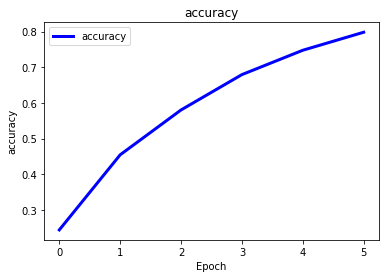

Name : loss max : 2.6203322410583496 min : 0.5693948864936829


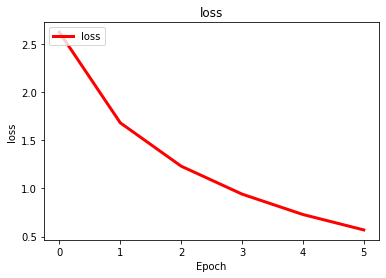

Name : val_accuracy max : 0.0 min : 0.0


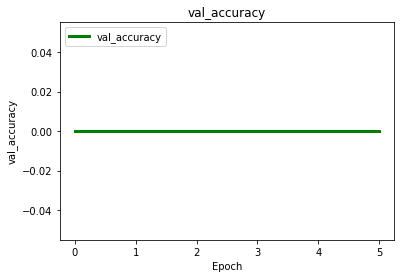

Name : val_loss max : 7.91775369644165 min : 3.4479172229766846


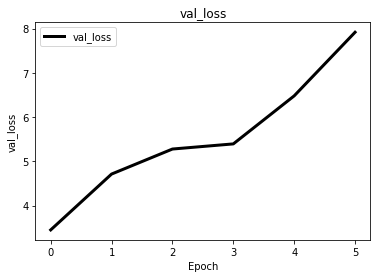

In [36]:
visualization('accuracy',hist,'Blue')
visualization('loss',hist,'Red')
visualization('val_accuracy',hist,'Green')
visualization('val_loss',hist,'Black')

In [38]:
model.load_weights('/content/drive/MyDrive/bestmodel.hdf5')
yt_one_hot=to_categorical(y_test)
res = model.evaluate(x_test, yt_one_hot)
print("test loss, test acc:", res)

94/94 [==============================] - 17s 185ms/step - loss: 2.2085 - accuracy: 0.2633
test loss, test acc: [2.208545207977295, 0.2633333206176758]


In [39]:
def my_predict(my_model,my_x_test):
  y_pred = my_model.predict(my_x_test)
  return y_pred

def my_f1_score(my_y_test,my_y_pred):
  f1 = f1_score(my_y_test, my_y_pred, average="micro")
  return f1

def my_conf_matrix(my_y_test,my_y_pred):
  cm = confusion_matrix(my_y_test, my_y_pred)
  cm_norm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
  sns.heatmap(cm_norm,cmap='Greens',annot=True,
              cbar_kws={'orientation' : 'vertical','label' : 'Color bar'},
              fmt='.2f'
              )
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

0.2633333333333333


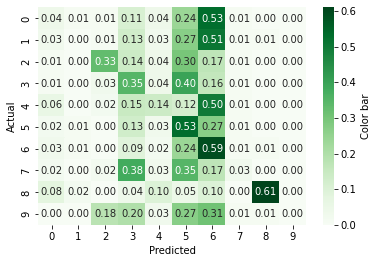

In [40]:
y_pred_res = my_predict(model,x_test)
y_pred_res = np.argmax(y_pred_res, axis=-1)
print(my_f1_score(y_test,y_pred_res))
my_conf_matrix(y_test,y_pred_res)

In [41]:
model.load_weights('/content/drive/MyDrive/best_val_acc.hdf5')
res = model.evaluate(x_test, yt_one_hot)
print("test loss, test acc:", res)

94/94 [==============================] - 24s 253ms/step - loss: 2.2085 - accuracy: 0.2633
test loss, test acc: [2.208545207977295, 0.2633333206176758]


0.2633333333333333


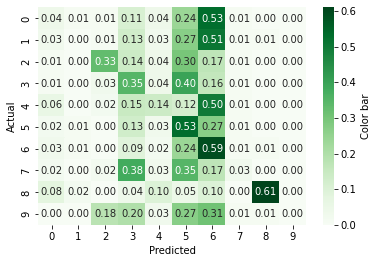

In [42]:
y_pred_res = my_predict(model,x_test)
y_pred_res = np.argmax(y_pred_res, axis=-1)
print(my_f1_score(y_test,y_pred_res))
my_conf_matrix(y_test,y_pred_res)

In [44]:
newpath = r'/content/drive/MyDrive/Model/' + name 

if not os.path.exists(newpath):
    os.makedirs(newpath)

import pickle

pickle_out = open('/content/drive/MyDrive/Model/' + name + 'model.pickle','wb')
pickle.dump(model,pickle_out)
pickle_out.close()

In [45]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_16 (Bat  (None, 98, 98, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 47, 47, 64)      

In [46]:
end = time.time()
print((end - start)/60)

72.82741411526997


In [47]:
pickle_in = open('/content/drive/MyDrive/Model/' + name + 'model.pickle','rb')
model = pickle.load(pickle_in)